> __Purpose:__ The goal of this NB is to train single user local models, and show performance of each user's model tested on every other user.

In [1]:
import torch
#import torch.nn as nn
#import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


In [2]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../utils'))
from ae_torch_classes import *
from data_loading_paths import *

In [4]:
#from utils.data_loading_paths import *

kai_laptop = True
brc_desktop = False

if kai_laptop:
    data_path = kai_data_path
    model_dir_path = kai_model_dir_path
    metadata_path = kai_metadata_path
elif brc_desktop:
    data_path = brc_data_path
    model_dir_path = brc_model_dir_path
    metadata_path = brc_metadata_path

metadata_cols_df = pd.read_pickle(metadata_path)

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

In [5]:
combined_emg_df = pd.concat([metadata_cols_df, pd.concat([emg_training_users_df, emg_test_users_df])], axis=1)
participants = combined_emg_df['Participant'].unique()

print(combined_emg_df.shape)
combined_emg_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [6]:
def embed_dataset(dim_reduc_model_str, X, num_train_gestures, num_features, num_rows_per_gesture=64):
    if dim_reduc_model_str == "AE9":
        hidden_dim_lst = [9]
        input_dim = 16
        RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
        RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))
    
        X_3DTensor = torch.tensor(X.to_numpy().reshape(num_train_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)
        X_embedding = RNNAE_9mir_EMGFull.encode(X_3DTensor)
        #print(f"X_embedding.shape: {X_embedding.shape}")
        X = X_embedding.detach().numpy().reshape(num_train_gestures, -1)
        #print(f"New embedded X_train.shape: {X.shape}")
    elif dim_reduc_model_str == "AE3":
        #hidden_dim_lst = ___
        #input_dim = 16
        #___ = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
        #___.load_state_dict(torch.load(model_dir_path+'___.pth'))
        pass
    elif dim_reduc_model_str == "PCA8":
        pca = PCA(n_components=8)
        X = pd.DataFrame(data=pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']).reset_index(drop=True).values.reshape(num_train_gestures, -1)
    elif dim_reduc_model_str == "PCA3":
        pass
    elif dim_reduc_model_str is None:
        X = X.values.reshape(num_train_gestures, -1)

    return X

In [7]:
def local_model_permuatation_testing(df, dim_reduc_model_str, gesture_cls_model="KNN", num_rows_per_gesture=64, batch_size=32, plot_heatmap=False, plot_clustermap=False, plot_title=None):

    participants = df['Participant'].unique()
    unique_gestures = df['Gesture_ID'].unique()
    
    num_train_gestures = len(df[df['Participant']=='P102']) // num_rows_per_gesture
    num_emg_features = df.shape[-1] - 3
    
    # Initialize a DataFrame to store the accuracies
    res_df = pd.DataFrame(index=participants, columns=participants, dtype=float)
    
    label_encoder = LabelEncoder()
    label_encoder.fit(unique_gestures)
    
    # Loop through each permutation of participants
    for train_participant in participants:
    
        train_df = df[df['Participant'] == train_participant]
        # Embed training data
        X_train = embed_dataset(dim_reduc_model_str, train_df.iloc[:, 3:], num_train_gestures, num_emg_features)
        # Encode training labels
        y_train = label_encoder.transform(train_df['Gesture_ID'].iloc[::num_rows_per_gesture])

        if gesture_cls_model=="KNN":
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(X_train, y_train)
        else:
            raise ValueError("Only KNN is currently supported")
        
        for test_participant in participants:
            if train_participant != test_participant:
                test_df = df[df['Participant'] == test_participant]
                # Embed testing data
                X_test = embed_dataset(dim_reduc_model_str, test_df.iloc[:, 3:], num_train_gestures, num_emg_features)
                # Encode testing labels
                y_test = label_encoder.transform(test_df['Gesture_ID'].iloc[::num_rows_per_gesture])

                if gesture_cls_model=="KNN":
                    y_pred = knn.predict(X_test)
                else:
                    raise ValueError("Only KNN is currently supported")
                accuracy = accuracy_score(y_test, y_pred)
                res_df.at[train_participant, test_participant] = accuracy

    if plot_heatmap:
        raise ValueError("Heatmap plotting is not yet supported")
    if plot_clustermap:
        raise ValueError("Clustermap plotting is not yet supported")

    np.fill_diagonal(res_df.values, 0)
    return res_df

## Autoencoder to 9D

In [8]:
emg_ae9_res_df = local_model_permuatation_testing(combined_emg_df, 'AE9')

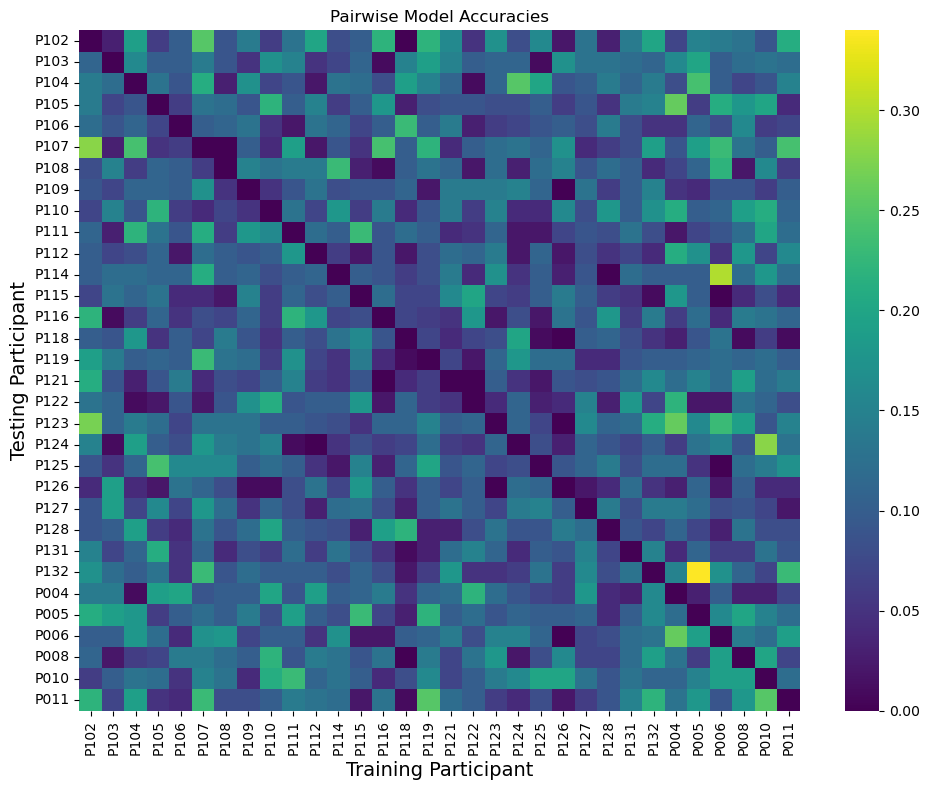

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(emg_ae9_res_df, cmap='viridis', fmt=".2f", xticklabels=participants, yticklabels=participants) #, annot=True
plt.xlabel('Training Participant', fontsize=14)
plt.ylabel('Testing Participant', fontsize=14)
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

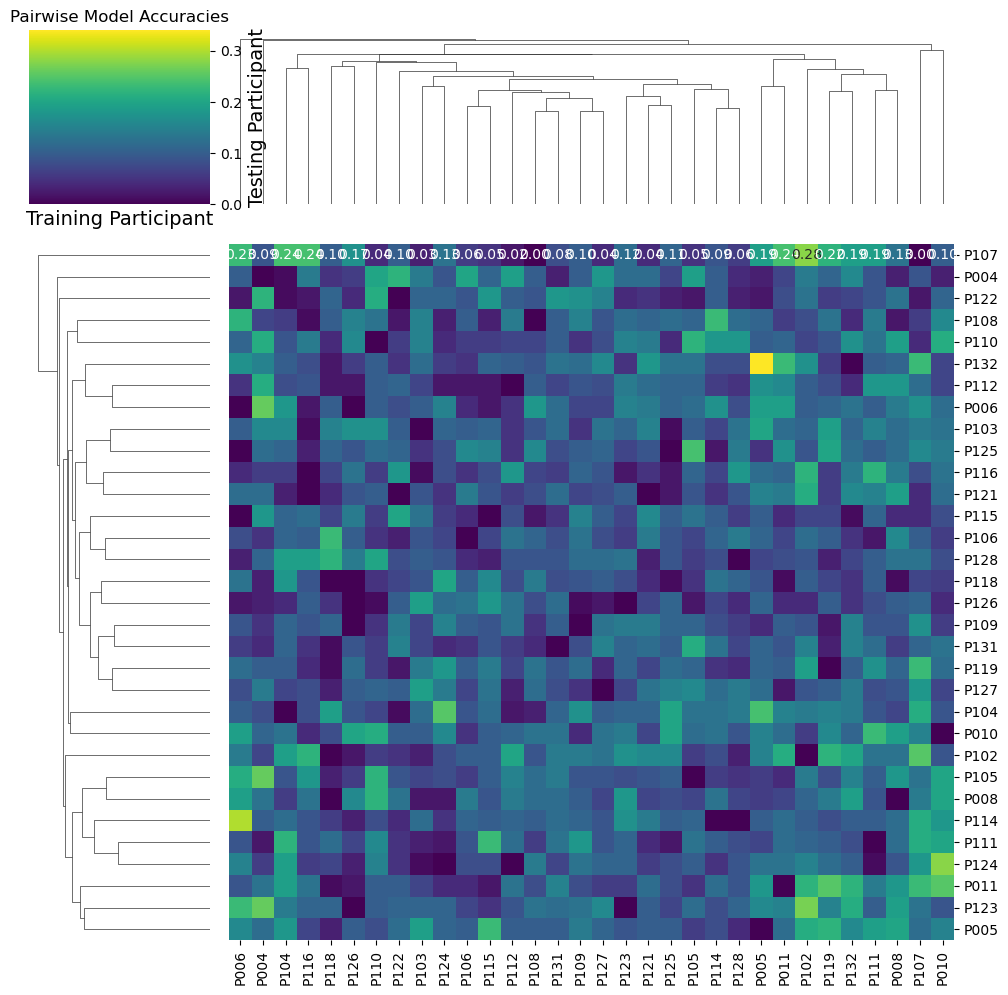

In [10]:
plt.figure(figsize=(10, 8))
sns.clustermap(emg_ae9_res_df, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Training Participant', fontsize=14)
plt.ylabel('Testing Participant', fontsize=14)
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## No Dim Reduction

In [11]:
emg_full_res_df = local_model_permuatation_testing(combined_emg_df, None)

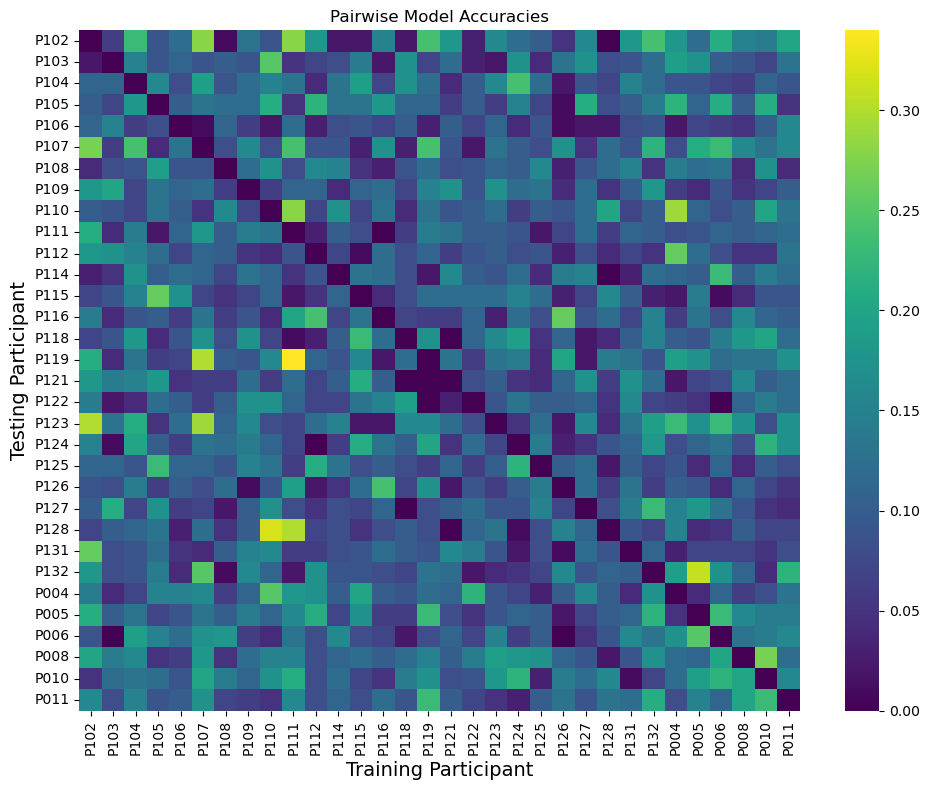

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(emg_full_res_df, cmap='viridis', fmt=".2f", xticklabels=participants, yticklabels=participants) #, annot=True
plt.xlabel('Training Participant', fontsize=14)
plt.ylabel('Testing Participant', fontsize=14)
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

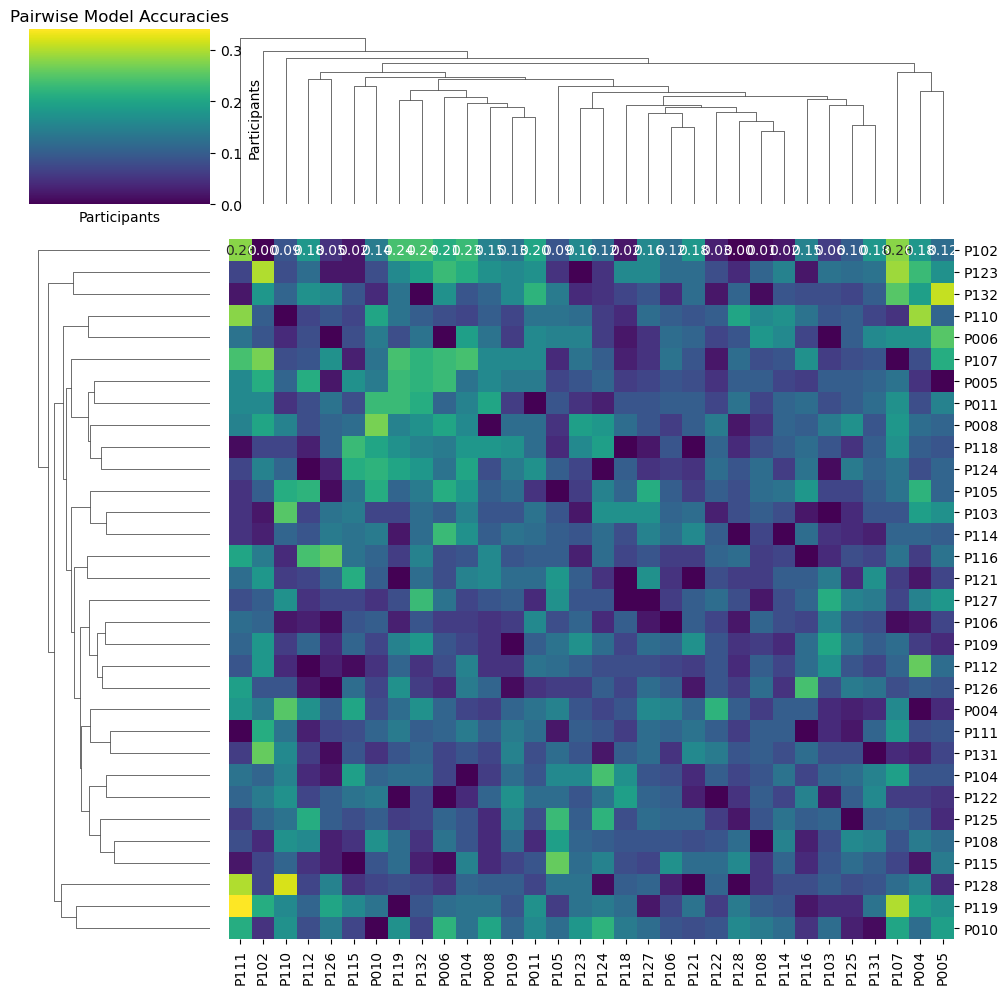

In [13]:
plt.figure(figsize=(10, 8))
sns.clustermap(emg_full_res_df, metric='euclidean', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## PCA 8

In [14]:
emg_pca8_res_df = local_model_permuatation_testing(combined_emg_df, "PCA8")

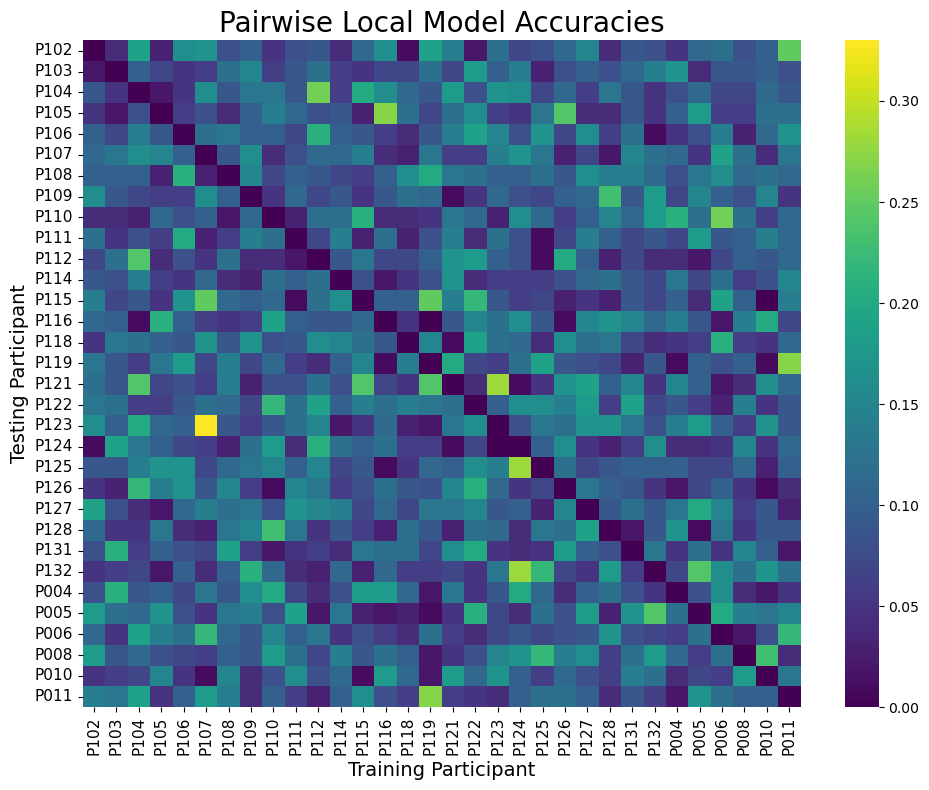

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(emg_pca8_res_df, cmap='viridis', fmt=".2f", xticklabels=participants, yticklabels=participants) #, annot=True
plt.xlabel('Training Participant', fontsize=14)
plt.ylabel('Testing Participant', fontsize=14)
plt.title('Pairwise Local Model Accuracies', fontsize=20)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

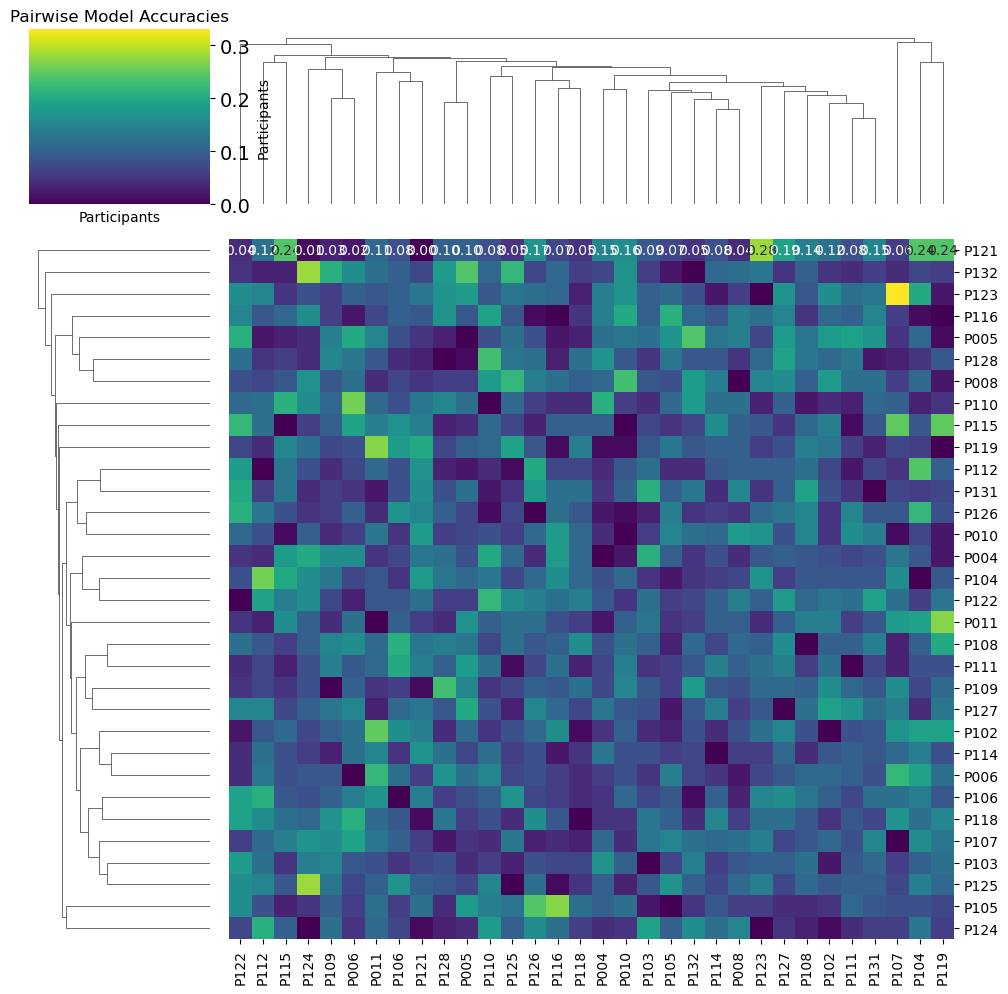

In [16]:
plt.figure(figsize=(10, 8))
sns.clustermap(emg_pca8_res_df, metric='euclidean', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
assert(False)

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, SpectralClustering

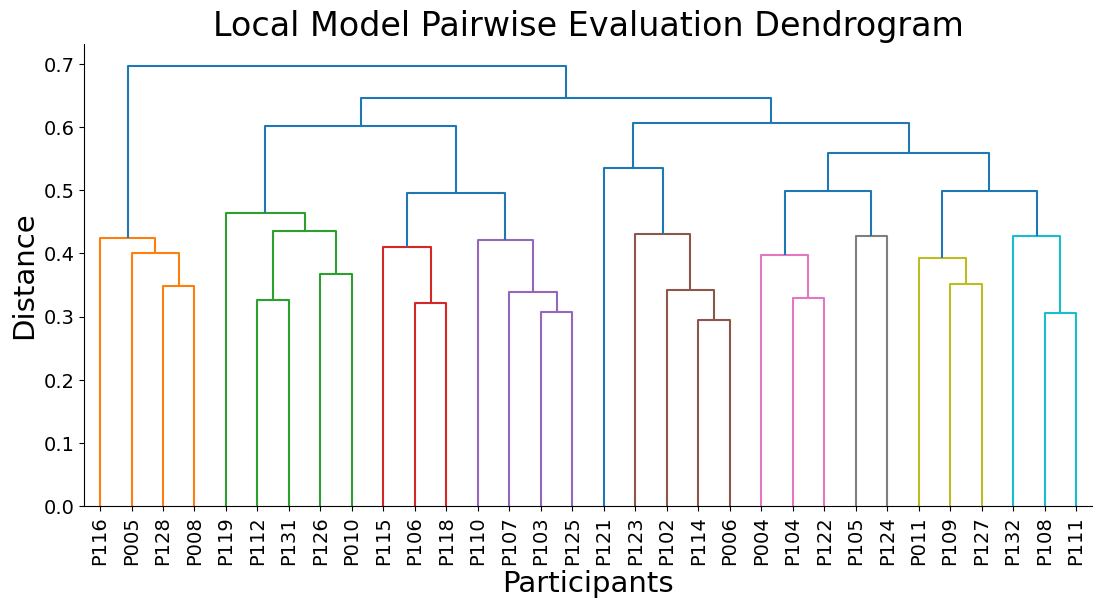

In [62]:
# Convert the DataFrame to a numpy array
data = emg_pca8_res_df.values

# Perform hierarchical clustering
Z = linkage(data, method='ward')

# Plot dendrogram
plt.figure(figsize=(13, 6))
#dendrogram(Z, labels=emg_pca8_res_df.index)
dendrogram(Z, labels=emg_pca8_res_df.index, leaf_font_size=16, leaf_rotation=90)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Local Model Pairwise Evaluation Dendrogram', fontsize=title_font)
plt.xlabel('Participants', fontsize=label_font)
plt.ylabel('Distance', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()


In [42]:
# Optional: Cut the dendrogram at a certain threshold to form flat clusters
max_d = 0.4
clusters = fcluster(Z, max_d, criterion='distance')
print("Hierarchical Clustering Labels:", clusters)

Hierarchical Clustering Labels: [11  9 14 15  7  9 18 17 10 18  4 11  8  3  7  6 13 14 12 16  9  5 17  1
  4 19 14  2 11  1  5 17]


In [43]:
max_d = 0.5
clusters = fcluster(Z, max_d, criterion='distance')
print("Hierarchical Clustering Labels:", clusters)

Hierarchical Clustering Labels: [4 3 6 6 3 3 7 7 3 7 2 4 3 1 3 2 5 6 4 6 3 2 7 1 2 7 6 1 4 1 2 7]
